## 분별 모델
- 표정을 보고 상대의 감정을 읽는다 - SVM, 다층퍼셉트론, 컨볼루션 신경망, LSTM, 강화학습

## 생성 모델 
- GAN

In [1]:
# 확률생성 모델을 MNIST 필기 숫자에 적용
import numpy as np
from tensorflow.keras.datasets import fashion_mnist

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# 0만 추출
(x_train, y_train), (x_test,y_test) = fashion_mnist.load_data()

In [3]:
X = x_train[y_train==0]

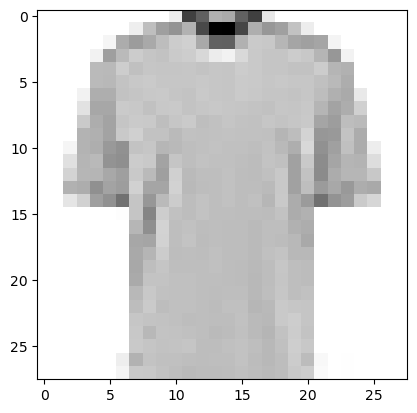

In [4]:
import matplotlib.pyplot as plt
# plt.imshow(X[0])
plt.imshow(X[-1], cmap='gray_r')

In [5]:
# 화소 수준의 생성 모델 적용
# 이미지는 명암이 0 ~ 255
X.shape, X[0].shape

((6000, 28, 28), (28, 28))

In [6]:
p = np.zeros((28,28,256))  # 0 ~ 255

In [7]:
for k in range(X.shape[0]):
    for i in range(X.shape[1]):
        for j in range(X.shape[2]):
            p[i][j][X[k][i][j]] += 1

p = p/X.shape[0]

In [8]:
# 확률 생성 모델을 이용해서 20개 샘플을 생성
Xnew = np.zeros((20,28,28))

In [9]:
for i in range(20):
    for r in range(28):
        for c in range(28):
            Xnew[i][r][c] = np.random.choice(range(256), p=p[r][c])

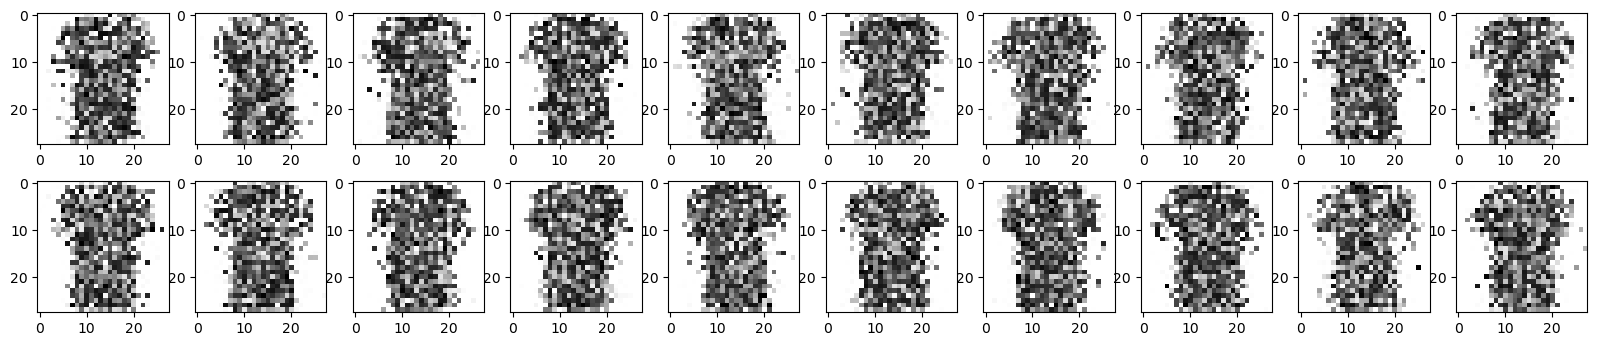

In [10]:
fig,ax = plt.subplots(2,10,figsize=(20,4))
for i in range(20):
    ax[i//10,i%10].imshow(Xnew[i],cmap='gray_r')
#     ax[i//10,i%10].xticks([])
#     ax[i//10,i%10].yticks([])

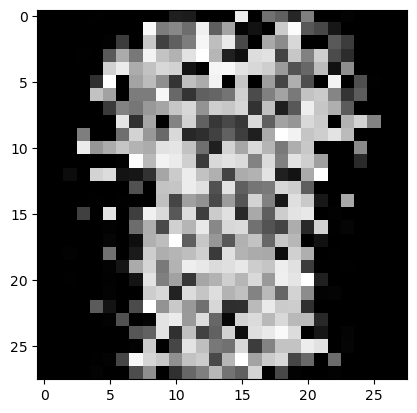

In [11]:
plt.imshow(Xnew[0],cmap='gray')

In [12]:
# 화소간의 상관관계를 고려하지 않았음 >> 화질 안좋음

---

## AutoEncoder (오토인코더) : 비지도 학습
1. 입력패턴과 출력패턴이 같은 신경망
2. 사람이 레이블을 달 필요가 없음
3. 고전적인 응용 : 영상압축, 잡음제거
4. 응용 : 특징 추출 또는 생성 모델
- 오토인코더를 생성 모델로 활용

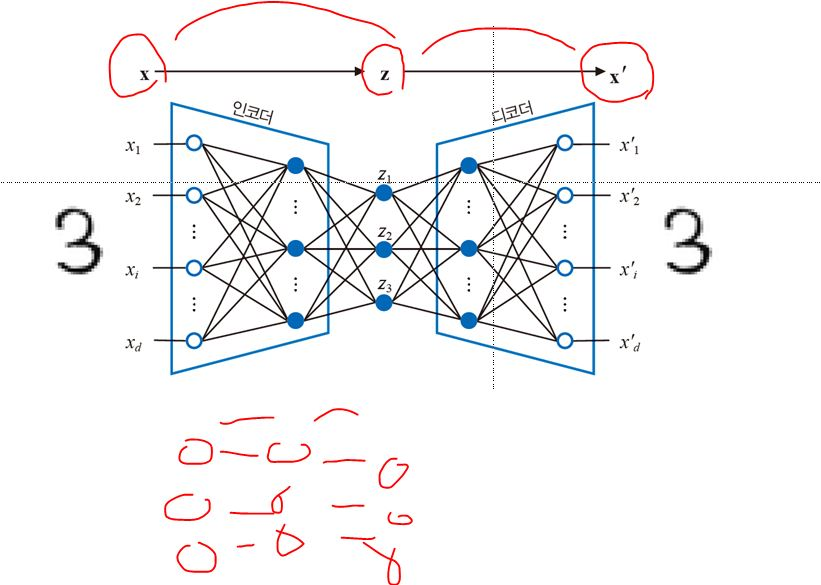

In [13]:
from IPython import display
display.Image('./img/037.jpg', width = 500, height = 500)

- 은닉층의 노드개수를 축소하여 설계
- 인코더는 차원을 축소
- 디코더는 차원을 회복
- z공간을 잠복 공간이라고 함 : latent space

In [14]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as k

In [15]:
# 데이터 로드
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()

In [16]:
# 데이터 스케일링
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [17]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [18]:
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [19]:
# 28 * 28 인 784 차원을 32차원으로 축소
# 잠복 공간의 z 차원을 32로 설정
zdim = 32

In [20]:
# 오토인코더의 인코더를 설정
encoder_input = Input(shape=(28,28,1))
x = Conv2D(32,(3,3), activation = 'relu', padding = 'same', strides = (1,1))(encoder_input)
x = Conv2D(64,(3,3), activation = 'relu', padding = 'same', strides = (2,2))(x)
x = Conv2D(64,(3,3), activation = 'relu', padding = 'same', strides = (2,2))(x)
x = Conv2D(64,(3,3), activation = 'relu', padding = 'same', strides = (1,1))(x)
x = Flatten()(x)
encoder_output = Dense(zdim)(x)
model_encoder = Model(encoder_input,encoder_output)
model_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 32)                100384

In [21]:
# 오토인코더의 디코더를 설정
# 인코더에서 summary한 내용을 잘 살펴보기!!

decoder_input = Input(shape=(zdim,))
x = Dense(3136)(decoder_input)
x = Reshape((7,7,64))(x)
x = Conv2DTranspose(64,(3,3),activation='relu', padding='same',strides=(1,1))(x)
x = Conv2DTranspose(64,(3,3),activation='relu', padding='same',strides=(2,2))(x)
x = Conv2DTranspose(32,(3,3),activation='relu', padding='same',strides=(2,2))(x)
x = Conv2DTranspose(1,(3,3),activation='relu', padding='same',strides=(1,1))(x)
# 마지막은 이미지 1개를 생성하기 위해 1,(3,3)을 해줌

decoder_output = x
model_decoder = Model(decoder_input,decoder_output)
model_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              103488    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 32)       1846

In [22]:
# 인코더와 디코더를 결합하여 오토인코더 모델 구축
model_input = encoder_input
model_output = model_decoder(encoder_output)
model = Model(model_input,model_output)

In [23]:
# 오토인코더 학습
model.compile(optimizer='Adam', loss='mse')
model.fit(x_train,x_train, epochs = 5, batch_size = 128, shuffle = True, validation_data=(x_test,x_test))

Epoch 1/5
469/469 [==============================] - 57s 118ms/step - loss: 0.0276 - val_loss: 0.0137
Epoch 2/5
469/469 [==============================] - 55s 117ms/step - loss: 0.0117 - val_loss: 0.0102
Epoch 3/5
469/469 [==============================] - 55s 117ms/step - loss: 0.0095 - val_loss: 0.0089
Epoch 4/5
469/469 [==============================] - 57s 122ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 5/5
469/469 [==============================] - 58s 123ms/step - loss: 0.0081 - val_loss: 0.0079


In [24]:
# 복원 실험
decoder_img = model.predict(x_test)
decoder_img

313/313 [==============================] - 4s 11ms/step


array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [25]:
import matplotlib.pyplot as plt

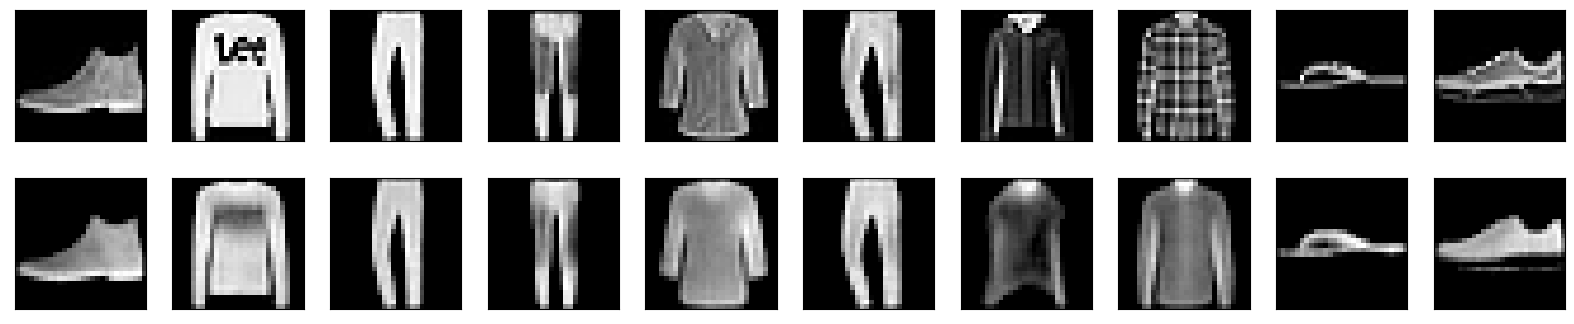

In [26]:
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    plt.subplot(2,n, i+1)
    plt.imshow(x_test[i].reshape(28,28),cmap='gray')
    plt.xticks([]);plt.yticks([]);
    plt.subplot(2,n,i+n+1)
    plt.imshow(decoder_img[i].reshape(28,28),cmap='gray')
    plt.xticks([]);plt.yticks([]);
plt.show()

### Functional API 방식 

In [27]:
# 인코더에서 잠복차원은 전체 데이터의 특징을 잘 반영하여 디코딩 했을 때 원본과 유사하게 나오면
# 인코더만 사용하면 특징을 잘 추출해내는 추출기로 활용 가능함
# 인코더 + 다층퍼셉트론(인공신경망) + SVM을 붙이면 훌륭한 필기 숫자 인식기가 됨
# 현재는 딥러닝 자체가 성능이 우수하기에 인코더를 굳이 사용하지 않음
# 대신 생성모델로 사용

In [28]:
# 학습된 오토인코더를 생성 모델로 활용

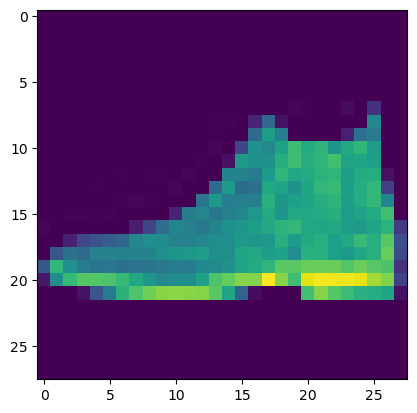

In [29]:
# 생성실험, 첫 번째 샘플의 잠복공간표현에 잡음을 섞어 새로운 샘플을 생성
plt.imshow(x_test[0])

In [30]:
x0 = x_test[0]
z = model_encoder.predict(x0.reshape(1,28,28,1))
np.round(z,3)

1/1 [==============================] - 0s 70ms/step


array([[ 0.039, -0.098,  0.738,  0.78 , -0.588,  3.407, -0.586, -1.585,
         1.058,  0.123,  1.502,  0.189,  0.368, -0.406, -0.911,  1.26 ,
        -2.802,  3.203, -2.847,  1.551,  1.179,  0.233, -1.015,  0.647,
         1.834,  0.163,  2.093, -0.227,  0.884, -0.518,  1.037,  0.409]],
      dtype=float32)

In [31]:
zz = np.zeros((20,zdim))
zz.shape

(20, 32)

In [32]:
# 잠복공간에 잡음을 섞음
for i in range(20):
    zz[i] =z[0]+(i-10)/10.0

In [33]:
# 디코더로 샘플을 생성
generated_img = model_decoder.predict(zz)

1/1 [==============================] - 0s 109ms/step


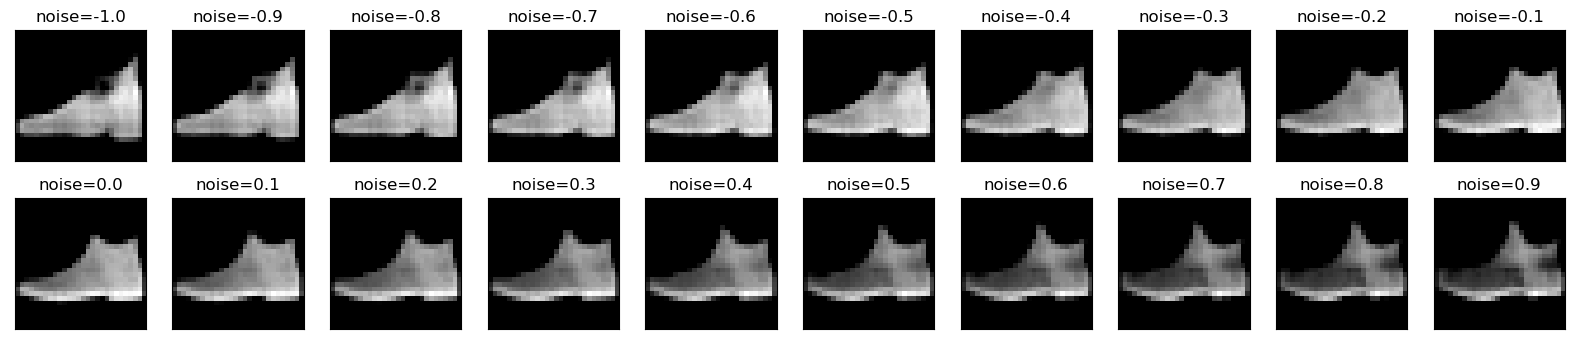

In [34]:
plt.figure(figsize=(20,4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(generated_img[i].reshape(28,28),cmap='gray')
    plt.xticks([]);plt.yticks([]);
    plt.title('noise='+str((i-10)/10.0))
plt.show()

In [35]:
x1,x2 = x_test[y_test==8][0], x_test[y_test==8][1]

In [36]:
# 생성실험 2: 같은 부류의 두 샘플 사이를 보간하여 새로운 샘플 생성
x_2_20 = np.array((x1,x2))
z = model_encoder.predict(x_2_20) # 잠복공간을 예측 32
zz = np.zeros((20,zdim))

# 두 잠복공간의 점을 잇는 선분상에서 20개의 점 생성
for i in range(20):
    alpha = i/(20.0 - 1.0)
    zz[i] = (1.0 - alpha) * z[0]+alpha*z[1]

# 두 사잇점에 대해 디코더로 샘플 생성
generated_img = model_decoder.predict(zz)

1/1 [==============================] - 0s 20ms/step


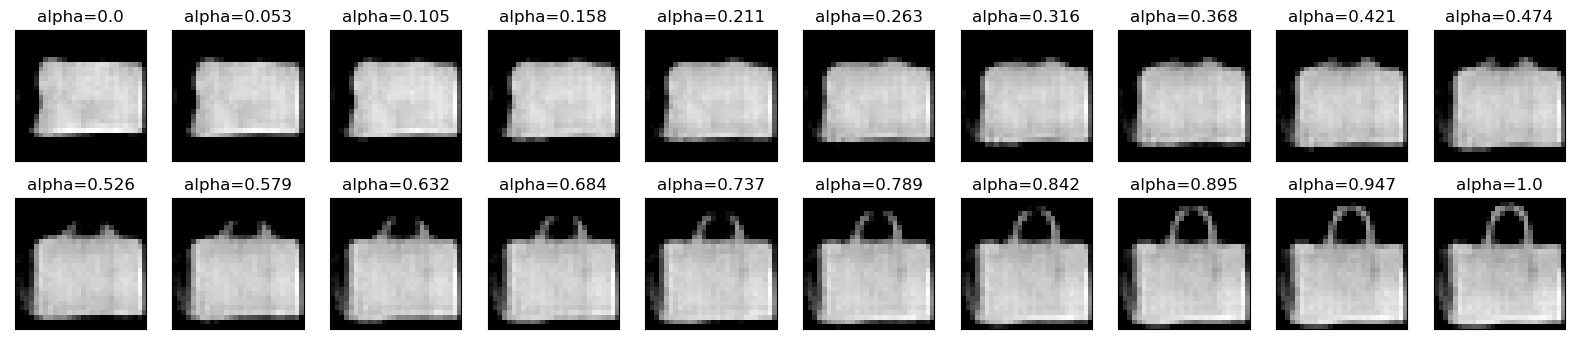

In [37]:
plt.figure(figsize=(20,4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(generated_img[i].reshape(28,28),cmap='gray')
    plt.xticks([]);plt.yticks([]);
    plt.title('alpha='+str(round(i/(20.0-1.0),3)))
plt.show()

In [38]:
# 오토인코더는 생성모델로 가능성이 있음
# 잠복공간의 점들중에는 품질이 하락이 다수 있음을 확인

In [39]:
# 시각화를 위해 잠복공간을 2차원으로 설정 

In [40]:
zdim = 2

Epoch 1/5
469/469 [==============================] - 56s 119ms/step - loss: 0.0450 - val_loss: 0.0339
Epoch 2/5
469/469 [==============================] - 54s 115ms/step - loss: 0.0328 - val_loss: 0.0316
Epoch 3/5
469/469 [==============================] - 55s 117ms/step - loss: 0.0311 - val_loss: 0.0316
Epoch 4/5
469/469 [==============================] - 60s 128ms/step - loss: 0.0302 - val_loss: 0.0297
Epoch 5/5
313/313 [==============================] - 3s 10ms/step


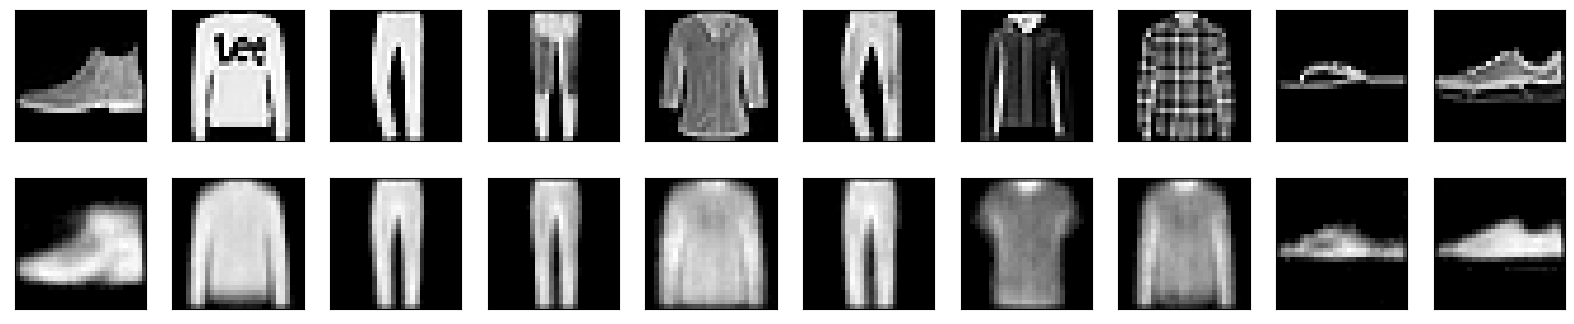

In [41]:
# 오토인코더
encoder_input = Input(shape=(28,28,1))
x = Conv2D(32,(3,3), activation = 'relu', padding = 'same', strides = (1,1))(encoder_input)
x = Conv2D(64,(3,3), activation = 'relu', padding = 'same', strides = (2,2))(x)
x = Conv2D(64,(3,3), activation = 'relu', padding = 'same', strides = (2,2))(x)
x = Conv2D(64,(3,3), activation = 'relu', padding = 'same', strides = (1,1))(x)
x = Flatten()(x)
encoder_output = Dense(zdim)(x)
model_encoder = Model(encoder_input,encoder_output)

#오토디코더
decoder_input = Input(shape=(zdim,))
x = Dense(3136)(decoder_input)
x = Reshape((7,7,64))(x)
x = Conv2DTranspose(64,(3,3),activation='relu', padding='same',strides=(1,1))(x)
x = Conv2DTranspose(64,(3,3),activation='relu', padding='same',strides=(2,2))(x)
x = Conv2DTranspose(32,(3,3),activation='relu', padding='same',strides=(2,2))(x)
x = Conv2DTranspose(1,(3,3),activation='relu', padding='same',strides=(1,1))(x)
decoder_output = x
model_decoder = Model(decoder_input,decoder_output)

#인코더 디코더 연결
model_input = encoder_input
model_output = model_decoder(encoder_output)
model = Model(model_input,model_output)

# 학습
model.compile(optimizer='Adam', loss='mse')
model.fit(x_train,x_train, epochs = 5, batch_size = 128, shuffle = True, validation_data=(x_test,x_test))

# 복원 
decoder_img = model.predict(x_test)

# 시각화
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    plt.subplot(2,n, i+1)
    plt.imshow(x_test[i].reshape(28,28),cmap='gray')
    plt.xticks([]);plt.yticks([]);
    plt.subplot(2,n,i+n+1)
    plt.imshow(decoder_img[i].reshape(28,28),cmap='gray')
    plt.xticks([]);plt.yticks([]);
plt.show()

32/32 [==============================] - 0s 5ms/step


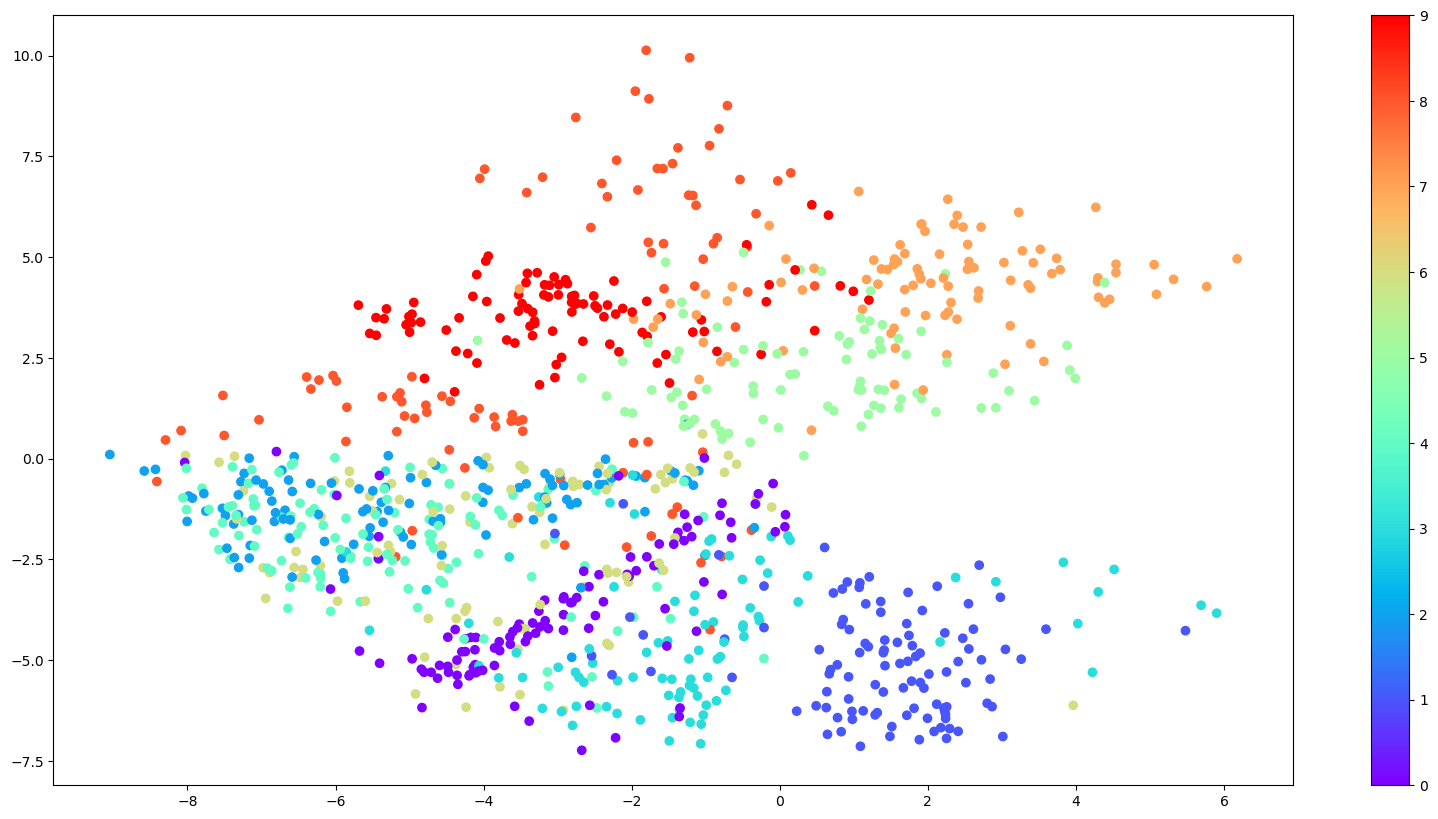

In [42]:
# 테스트 집합의 분포를 2차원 잠복 공간에 시각화
plt.figure(figsize=(20,10))
n = 1000
xx = x_test[:n]
z = model_encoder.predict(xx)
sc = plt.scatter(z[:,0],z[:,1],c=y_test[:n], cmap='rainbow')
plt.colorbar(sc)